### os.listdir()
用于返回指定的文件夹包含的文件或文件夹的名字的列表。
語法: os.listdir(path)

In [6]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from google.colab.patches import cv2_imshow

In [ ]:
import pandas as pd

df = pd.DataFrame({
  "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
  "Contestant": ["Alex", "Alex", "Alex", "Jordan", "Jordan", "Jordan"],
  "Number Eaten": [2, 1, 3, 1, 3, 2],
})


# Plotly Express

import plotly.express as px

fig = px.bar(df, x="Fruit", y="Number Eaten", color="Contestant", barmode="group")
fig.show()


# Graph Objects

import plotly.graph_objects as go

fig = go.Figure()
for contestant, group in df.groupby("Contestant"):
    fig.add_trace(go.Bar(x=group["Fruit"], y=group["Number Eaten"], name=contestant,
      hovertemplate="Contestant=%s<br>Fruit=%%{x}<br>Number Eaten=%%{y}<extra></extra>"% contestant))
fig.update_layout(legend_title_text = "Contestant")
fig.update_xaxes(title_text="Fruit")
fig.update_yaxes(title_text="Number Eaten")
fig.show()

In [33]:
# import the necessary packages
import imutils
import cv2
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread("1 no.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# threshold: 二值化黑白影像
# erode: 移除影像中的小白雜點,雜訊
# dilate: 將剛剛erode的影像膨脹回來。
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
# find contours in thresholded image, then grab the largest
# one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

In [34]:
# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

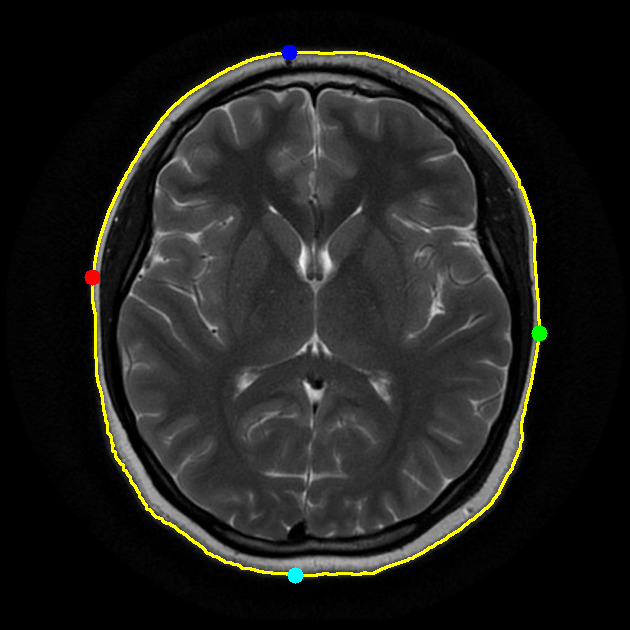

-1

In [35]:
# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv2.drawContours(image, [c], -1, (0, 255, 255), 2)
cv2.circle(image, extLeft, 8, (0, 0, 255), -1)
cv2.circle(image, extRight, 8, (0, 255, 0), -1)
cv2.circle(image, extTop, 8, (255, 0, 0), -1)
cv2.circle(image, extBot, 8, (255, 255, 0), -1)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

# Erosion 影像侵蝕

這篇要介紹影像處理中的型態變換，首先先介紹 Erosion 影像侵蝕。

1.   Erosion 影像侵蝕對於移除影像中的小白雜點很有幫助，可用來去噪，例如影像中的小雜點，雜訊。
2.   細化影像，消除毛刺。


影像侵蝕的概念就是將影像中白色區域(或高亮)進行細化或縮減，運算完的結果圖比原圖的白色區域更小，也可想像成讓該物體瘦一圈，而這一圈的寬度是由捲積 kernel 的大小所決定的，
實際上捲積 kernel 沿著影樣滑動並計算，如果捲積 kernel m x n 範圍內所有像素值都是1，那麼新的像素值就保持原來的值，
否則新的像素值為0，這表示捲積 kernel 掃過的所有像素都會被腐蝕或侵蝕掉(變為0)，所以整張影像的白色區域會變少。

cv2.erode() 的第一個參數為二值化的影像， 第二個參數為使用的捲積 kernel，第三個參數為迭代次數(預設為1)，
範例中的 kernel 捲積大小為 3x3，可以改成 5x5 或 7x7 較為常見，預設值為 3x3

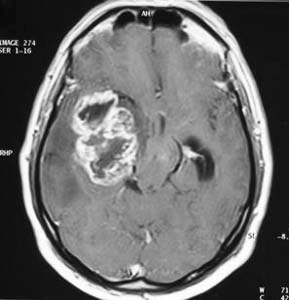

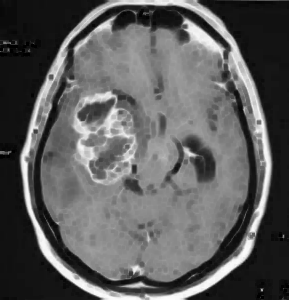

-1

In [18]:
image = cv2.imread('Y14.jpg', 0)
kernel = np.ones((3,3), np.uint8)
erosion = cv2.erode(image, kernel, iterations = 1)

cv2_imshow(image)
cv2_imshow(erosion)

cv2.waitKey(0)

# Dilation 影像膨脹

*   Dilation 影像膨脹通常是配合著影像侵蝕 Erosion 使用，先使用侵蝕的方式使影像中的線條變窄，同時也去除雜訊，之後再透過 Dilation 將影像膨脹回來。
*   用來連接兩個很靠近但分開的物體。



影像膨脹的概念就是將影像中白色區域(或高亮)進行擴張，運算完的結果圖比原圖的白色區域更大，也可想像成讓該物體胖一圈，而這一圈的寬度是由捲積 kernel 的大小所決定的，
在實際上捲積 kernel 沿著影樣滑動並計算，如果捲積 kernel m x n 範圍內只要有一個像素值是1，那麼新的像素值就為1，
否則新的像素值保持原來的像素值，這表示捲積 kernel 掃過的所有像素都會被擴張或膨脹(變為1)，所以整張影像的白色區域會變多。

cv2.dilate() 的第一個參數為二值化的影像， 第二個參數為使用的捲積 kernel，第三個參數為迭代次數(預設為1)，
範例中的 kernel 捲積大小為 3x3，可以改成 5x5 或 7x7 較為常見，預設值為 3x3

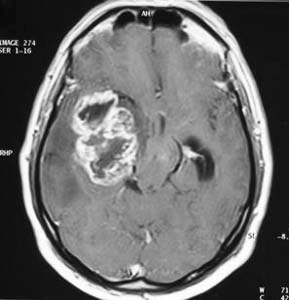

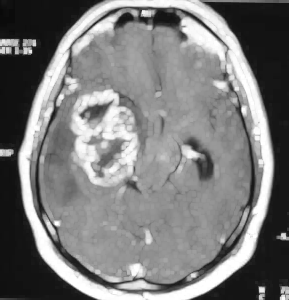

-1

In [20]:
image = cv2.imread('Y14.jpg', 0)
kernel = np.ones((3,3), np.uint8)
dilation = cv2.dilate(image, kernel, iterations = 1)

cv2_imshow(image)
cv2_imshow(dilation)
cv2.waitKey(0)